# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '08'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="graupel"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                   (cell: 2684736)
Dimensions without coordinates: cell
Data variables: (12/97)
    time                      (cell) float32 ...
    q_cloud                   (cell) float32 ...
    n_cloud                   (cell) float32 ...
    q_rain                    (cell) float32 ...
    n_rain                    (cell) float32 ...
    q_ice                     (cell) float32 ...
    ...                        ...
    frze_graupel_rain_mass    (cell) float32 ...
    frze_graupel_rain_rmass   (cell) float32 ...
    frze_graupel_rain_rvol    (cell) float32 ...
    frze_graupel_rain_liq     (cell) float32 ...
    rime_graupel_rain_num     (cell) float32 ...
    rime_graupel_rain_mass    (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     So  5 Jun 2022 13:37:07 CEST
    nfiles:   18051


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedsnow.values
    n_s  = xr.open_dataset(fname).n_rimedsnow.values
    r_s  = xr.open_dataset(fname).rime_rimedsnow.values
    v_s  = xr.open_dataset(fname).rvol_rimedsnow.values
    # reflectivity
    z_s  = xr.open_dataset(fname).z_rimedsnow.values
    # some numerical lower bounds
    q_min = 1e-20
    n_min = 1e-20
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*n_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    z_s = np.log(z_s, where=z_s>q_min, out=np.nan*n_s)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ z_s, q_s, n_s, r_s, v_s, temp, rho ]))
    dataset = dataset.T
    dataset.columns = [ 'z_s', 'q_s', 'n_s', 'r_s', 'v_s', 'temp', 'rho' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

In [8]:
df.describe()

z_s            q_s            n_s            r_s  \
count  604000.000000  604000.000000  604000.000000  604000.000000   
mean      -11.669885      -5.823854       2.816020      -6.203592   
std         8.604532       3.233736       5.992005       3.310946   
min       -46.049004     -29.587112     -14.498609     -35.500221   
25%       -17.024993      -5.739625      -1.194881      -6.273933   
50%       -12.761233      -4.875222       4.283849      -5.246997   
75%        -4.902499      -4.327765       7.658039      -4.562110   
max         6.959019      -2.958918      14.306541      -3.173640   

                 v_s           temp            rho  
count  604000.000000  604000.000000  604000.000000  
mean      -12.482997     269.731903       1.086106  
std         3.298000       6.466186       0.110762  
min       -40.529922     246.070007       0.615000  
25%       -12.445828     266.140015       1.017000  
50%       -11.592521     271.809998       1.107000  
75%       -10.987369     274.220001       1.170000  
max        -8.316296     286.739990       1.289000

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

z_s       q_s       n_s       r_s        v_s        temp    rho
0 -21.087023 -7.384228  8.640224 -7.980261 -13.568104  262.369995  0.962
3 -20.661324 -7.181376  8.640137 -7.647512 -13.291611  262.660004  0.967
4 -20.561062 -7.133715  8.638490 -7.575391 -13.233462  262.769989  0.968
5 -20.477579 -7.093760  8.637321 -7.516524 -13.186528  262.880005  0.970
6 -20.408821 -7.060522  8.635776 -7.468770 -13.148964  262.989990  0.972

In [11]:
dataset_train.describe()

z_s            q_s            n_s            r_s  \
count  422431.000000  422431.000000  422431.000000  422431.000000   
mean      -11.661613      -5.821134       2.815399      -6.200778   
std         8.601347       3.227768       5.992243       3.306088   
min       -46.047512     -29.587112     -14.498609     -35.500221   
25%       -17.017640      -5.739321      -1.189791      -6.271813   
50%       -12.748733      -4.874895       4.281101      -5.246617   
75%        -4.893739      -4.326932       7.655580      -4.561249   
max         6.958543      -2.958918      14.306541      -3.173640   

                 v_s           temp            rho  
count  422431.000000  422431.000000  422431.000000  
mean      -12.480537     269.730225       1.086064  
std         3.293071       6.462251       0.110726  
min       -40.529922     246.089996       0.617000  
25%       -12.442390     266.130005       1.017000  
50%       -11.592727     271.809998       1.107000  
75%       -10.988670     274.220001       1.170000  
max        -8.316296     286.739990       1.289000

In [12]:
dataset_test.describe()

z_s           q_s           n_s           r_s           v_s  \
count  90809.000000  90809.000000  90809.000000  90809.000000  90809.000000   
mean     -11.683118     -5.827975      2.823617     -6.207817    -12.485834   
std        8.599690      3.250672      5.988096      3.322644      3.311143   
min      -46.041355    -29.572929    -14.498609    -31.417999    -38.233833   
25%      -17.027534     -5.724679     -1.192901     -6.270755    -12.448858   
50%      -12.802420     -4.872801      4.288842     -5.243356    -11.589062   
75%       -4.912511     -4.331562      7.673735     -4.565661    -10.979361   
max        6.959019     -3.081094     14.304765     -3.328217     -8.738650   

               temp           rho  
count  90809.000000  90809.000000  
mean     269.737701      1.086287  
std        6.472181      0.110747  
min      246.289993      0.618000  
25%      266.190002      1.018000  
50%      271.809998      1.107000  
75%      274.220001      1.170000  
max      286.200012      1.288000

In [13]:
dataset_val.describe()

z_s           q_s           n_s           r_s           v_s  \
count  90760.000000  90760.000000  90760.000000  90760.000000  90760.000000   
mean     -11.695158     -5.832395      2.811307     -6.212466    -12.491597   
std        8.624205      3.244496      5.994866      3.321814      3.307753   
min      -46.049004    -29.580910    -14.498609    -32.501759    -39.059330   
25%      -17.060551     -5.752235     -1.220238     -6.286816    -12.459218   
50%      -12.778809     -4.878607      4.288155     -5.253038    -11.594987   
75%       -4.932168     -4.328524      7.654016     -4.562685    -10.991175   
max        6.953302     -3.033413     14.206268     -3.287717     -8.866183   

               temp           rho  
count  90760.000000  90760.000000  
mean     269.734070      1.086124  
std        6.478545      0.110943  
min      246.070007      0.615000  
25%      266.160004      1.017000  
50%      271.820007      1.107000  
75%      274.230011      1.171000  
max      286.649994      1.287000

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
#    idx = dataset[ dataset['v_s'] > -1 ].index
#    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

z_s            q_s            n_s            r_s  \
count  416676.000000  416676.000000  416676.000000  416676.000000   
mean      -11.291885      -5.580869       2.958680      -5.961171   
std         8.044381       2.500696       5.895207       2.605958   
min       -39.857662     -19.999056     -14.498609     -35.500221   
25%       -16.846580      -5.679139      -0.878712      -6.202729   
50%       -12.610948      -4.858122       4.367148      -5.227300   
75%        -4.740618      -4.317888       7.707602      -4.552862   
max         6.958543      -2.958918      14.306541      -3.173640   

                 v_s           temp            rho  
count  416676.000000  416676.000000  416676.000000  
mean      -12.242245     269.733459       1.086263  
std         2.599530       6.486416       0.110907  
min       -40.529922     246.089996       0.712000  
25%       -12.388776     266.100006       1.017000  
50%       -11.574726     271.869995       1.107000  
75%       -10.979419     274.239990       1.171000  
max        -8.316296     286.739990       1.289000

In [17]:
dataset_test.describe()

z_s           q_s           n_s           r_s           v_s  \
count  89544.000000  89544.000000  89544.000000  89544.000000  89544.000000   
mean     -11.304413     -5.582455      2.969234     -5.962961    -12.242289   
std        8.028305      2.513230      5.890051      2.610225      2.605487   
min      -39.692352    -19.994413    -14.498609    -25.938234    -32.715260   
25%      -16.852820     -5.666234     -0.877082     -6.201939    -12.393354   
50%      -12.652469     -4.856565      4.377039     -5.223349    -11.571455   
75%       -4.758383     -4.321402      7.725529     -4.556952    -10.968670   
max        6.959019     -3.081094     14.304765     -3.328217     -8.738650   

               temp           rho  
count  89544.000000  89544.000000  
mean     269.740417      1.086493  
std        6.497058      0.110965  
min      246.289993      0.712000  
25%      266.149994      1.018000  
50%      271.859985      1.107000  
75%      274.250000      1.171000  
max      286.200012      1.288000

### Pairplot

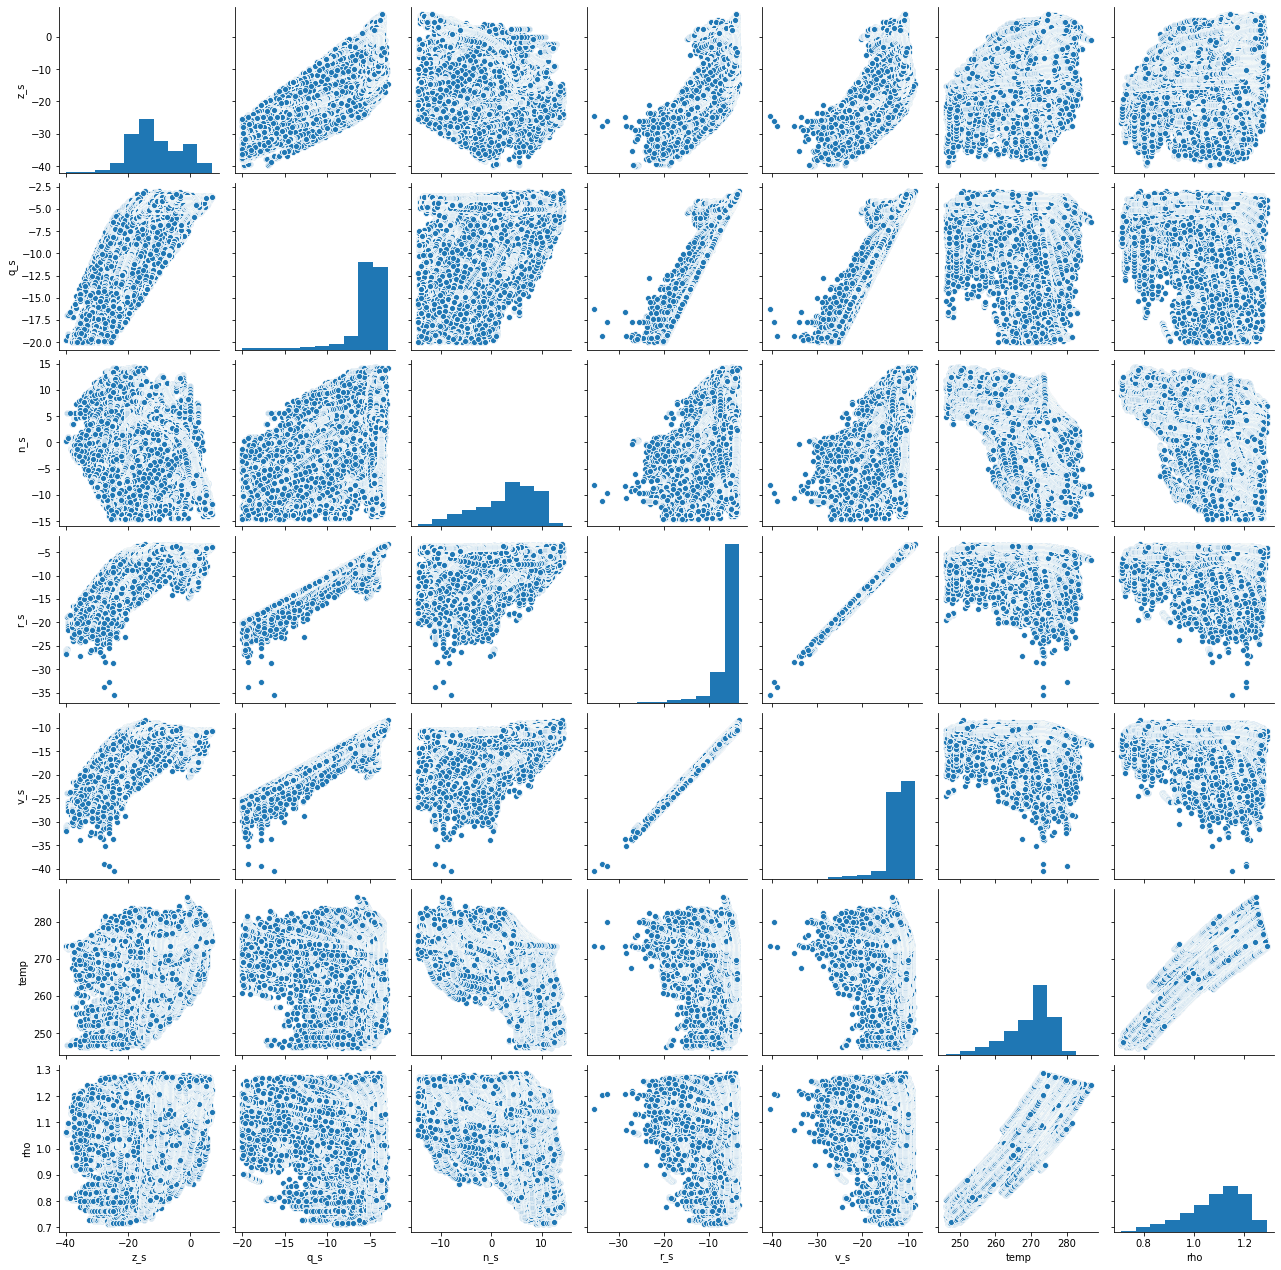

In [19]:
sns.pairplot(dataset_train[["z_s","q_s","n_s","r_s","v_s","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [20]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()
train_dataset5 = dataset_train.copy()

In [21]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()
test_dataset5 = dataset_test.copy()

In [22]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()
val_dataset5 = dataset_val.copy()

In [23]:
train_dataset1 = train_dataset1.drop(['temp','rho'], axis=1)
train_dataset2 = train_dataset2.drop(['temp'], axis=1)
#train_dataset3 = train_dataset3.drop(['ssi'], axis=1)
#train_dataset4 = train_dataset4.drop(['zi'], axis=1)
#train_dataset5 = train_dataset5.drop(['qs'], axis=1)

In [24]:
test_dataset1 = test_dataset1.drop(['temp','rho'], axis=1)
test_dataset2 = test_dataset2.drop(['temp'], axis=1)
#test_dataset3 = test_dataset3.drop(['ssi'], axis=1)
#test_dataset4 = test_dataset4.drop(['zi'], axis=1)
#test_dataset5 = test_dataset5.drop(['qs'], axis=1)

In [25]:
val_dataset1 = val_dataset1.drop(['temp','rho'], axis=1)
val_dataset2 = val_dataset2.drop(['temp'], axis=1)
#val_dataset3 = val_dataset3.drop(['ssi'], axis=1)
#val_dataset4 = val_dataset4.drop(['zi'], axis=1)
#val_dataset5 = val_dataset5.drop(['qs'], axis=1)

In [26]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("z_s")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s  416676.0  -5.580869  2.500696 -19.999056  -5.679139  -4.858122   
n_s  416676.0   2.958680  5.895207 -14.498609  -0.878712   4.367148   
r_s  416676.0  -5.961171  2.605958 -35.500221  -6.202729  -5.227300   
v_s  416676.0 -12.242245  2.599530 -40.529922 -12.388776 -11.574726   

           75%        max  
q_s  -4.317888  -2.958918  
n_s   7.707602  14.306541  
r_s  -4.552862  -3.173640  
v_s -10.979419  -8.316296

In [27]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("z_s")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%  \
q_s  416676.0  -5.580869  2.500696 -19.999056  -5.679139  -4.858122   
n_s  416676.0   2.958680  5.895207 -14.498609  -0.878712   4.367148   
r_s  416676.0  -5.961171  2.605958 -35.500221  -6.202729  -5.227300   
v_s  416676.0 -12.242245  2.599530 -40.529922 -12.388776 -11.574726   
rho  416676.0   1.086263  0.110907   0.712000   1.017000   1.107000   

           75%        max  
q_s  -4.317888  -2.958918  
n_s   7.707602  14.306541  
r_s  -4.552862  -3.173640  
v_s -10.979419  -8.316296  
rho   1.171000   1.289000

In [28]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("z_s")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std         min         25%         50%  \
q_s   416676.0   -5.580869  2.500696  -19.999056   -5.679139   -4.858122   
n_s   416676.0    2.958680  5.895207  -14.498609   -0.878712    4.367148   
r_s   416676.0   -5.961171  2.605958  -35.500221   -6.202729   -5.227300   
v_s   416676.0  -12.242245  2.599530  -40.529922  -12.388776  -11.574726   
temp  416676.0  269.733459  6.486416  246.089996  266.100006  271.869995   
rho   416676.0    1.086263  0.110907    0.712000    1.017000    1.107000   

             75%         max  
q_s    -4.317888   -2.958918  
n_s     7.707602   14.306541  
r_s    -4.552862   -3.173640  
v_s   -10.979419   -8.316296  
temp  274.239990  286.739990  
rho     1.171000    1.289000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [29]:
# pop does not work for multiple columns, use copy instead

labels = [ 'z_s' ]

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [31]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [32]:
train_labels.describe()

z_s
count  416676.000000
mean      -11.291885
std         8.044381
min       -39.857662
25%       -16.846580
50%       -12.610948
75%        -4.740618
max         6.958543

In [33]:
train_dataset1.describe()

q_s            n_s            r_s            v_s
count  416676.000000  416676.000000  416676.000000  416676.000000
mean       -5.580869       2.958680      -5.961171     -12.242245
std         2.500696       5.895207       2.605958       2.599530
min       -19.999056     -14.498609     -35.500221     -40.529922
25%        -5.679139      -0.878712      -6.202729     -12.388776
50%        -4.858122       4.367148      -5.227300     -11.574726
75%        -4.317888       7.707602      -4.552862     -10.979419
max        -2.958918      14.306541      -3.173640      -8.316296

In [34]:
train_dataset2.describe()

q_s            n_s            r_s            v_s  \
count  416676.000000  416676.000000  416676.000000  416676.000000   
mean       -5.580869       2.958680      -5.961171     -12.242245   
std         2.500696       5.895207       2.605958       2.599530   
min       -19.999056     -14.498609     -35.500221     -40.529922   
25%        -5.679139      -0.878712      -6.202729     -12.388776   
50%        -4.858122       4.367148      -5.227300     -11.574726   
75%        -4.317888       7.707602      -4.552862     -10.979419   
max        -2.958918      14.306541      -3.173640      -8.316296   

                 rho  
count  416676.000000  
mean        1.086263  
std         0.110907  
min         0.712000  
25%         1.017000  
50%         1.107000  
75%         1.171000  
max         1.289000

In [35]:
train_dataset3.describe()

q_s            n_s            r_s            v_s  \
count  416676.000000  416676.000000  416676.000000  416676.000000   
mean       -5.580869       2.958680      -5.961171     -12.242245   
std         2.500696       5.895207       2.605958       2.599530   
min       -19.999056     -14.498609     -35.500221     -40.529922   
25%        -5.679139      -0.878712      -6.202729     -12.388776   
50%        -4.858122       4.367148      -5.227300     -11.574726   
75%        -4.317888       7.707602      -4.552862     -10.979419   
max        -2.958918      14.306541      -3.173640      -8.316296   

                temp            rho  
count  416676.000000  416676.000000  
mean      269.733459       1.086263  
std         6.486416       0.110907  
min       246.089996       0.712000  
25%       266.100006       1.017000  
50%       271.869995       1.107000  
75%       274.239990       1.171000  
max       286.739990       1.289000

### Normalize the features

In [36]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [37]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std        min       25%       50%       75%  \
q_s  416676.0 -2.138427e-07  1.0  -5.765670 -0.039297  0.289018  0.505052   
n_s  416676.0  3.173651e-08  1.0  -2.961268 -0.650934  0.238917  0.805556   
r_s  416676.0 -3.524844e-07  1.0 -11.335198 -0.092695  0.281613  0.540419   
v_s  416676.0 -1.552012e-07  1.0 -10.881842 -0.056368  0.256784  0.485790   

          max  
q_s  1.048488  
n_s  1.924930  
r_s  1.069676  
v_s  1.510253

In [38]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std        min       25%       50%       75%  \
q_s  416676.0 -2.138427e-07  1.0  -5.765670 -0.039297  0.289018  0.505052   
n_s  416676.0  3.173651e-08  1.0  -2.961268 -0.650934  0.238917  0.805556   
r_s  416676.0 -3.524844e-07  1.0 -11.335198 -0.092695  0.281613  0.540419   
v_s  416676.0 -1.552012e-07  1.0 -10.881842 -0.056368  0.256784  0.485790   
rho  416676.0  5.839612e-07  1.0  -3.374563 -0.624512  0.186979  0.764039   

          max  
q_s  1.048488  
n_s  1.924930  
r_s  1.069676  
v_s  1.510253  
rho  1.827994

In [39]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std        min       25%       50%       75%  \
q_s   416676.0 -2.138427e-07  1.0  -5.765670 -0.039297  0.289018  0.505052   
n_s   416676.0  3.173651e-08  1.0  -2.961268 -0.650934  0.238917  0.805556   
r_s   416676.0 -3.524844e-07  1.0 -11.335198 -0.092695  0.281613  0.540419   
v_s   416676.0 -1.552012e-07  1.0 -10.881842 -0.056368  0.256784  0.485790   
temp  416676.0 -4.144979e-06  1.0  -3.645074 -0.560163  0.329386  0.694764   
rho   416676.0  5.839612e-07  1.0  -3.374563 -0.624512  0.186979  0.764039   

           max  
q_s   1.048488  
n_s   1.924930  
r_s   1.069676  
v_s   1.510253  
temp  2.621869  
rho   1.827994

### Normalize the labels

In [40]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min       25%        50%       75%  \
z_s  416676.0 -11.291885  8.044381 -39.857662 -16.84658 -12.610948 -4.740618   

          max  
z_s  6.958543

In [41]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [42]:
DNNstring='16x16x16'

def build_model_sigm(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [43]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(4,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [45]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.84150153],
       [-0.8437333 ],
       [-0.8442242 ],
       [-0.8446256 ],
       [-0.8449522 ],
       [-0.8454334 ],
       [-0.845608  ],
       [-0.84575164],
       [-0.8458655 ],
       [-0.8459568 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [46]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [47]:
activ = "sigm"
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0476,  mae:0.1358,  mse:0.0476,  val_loss:0.0291,  val_mae:0.1287,  val_mse:0.0291,  
..................................................................

Text(0, 0.5, 'MAE')

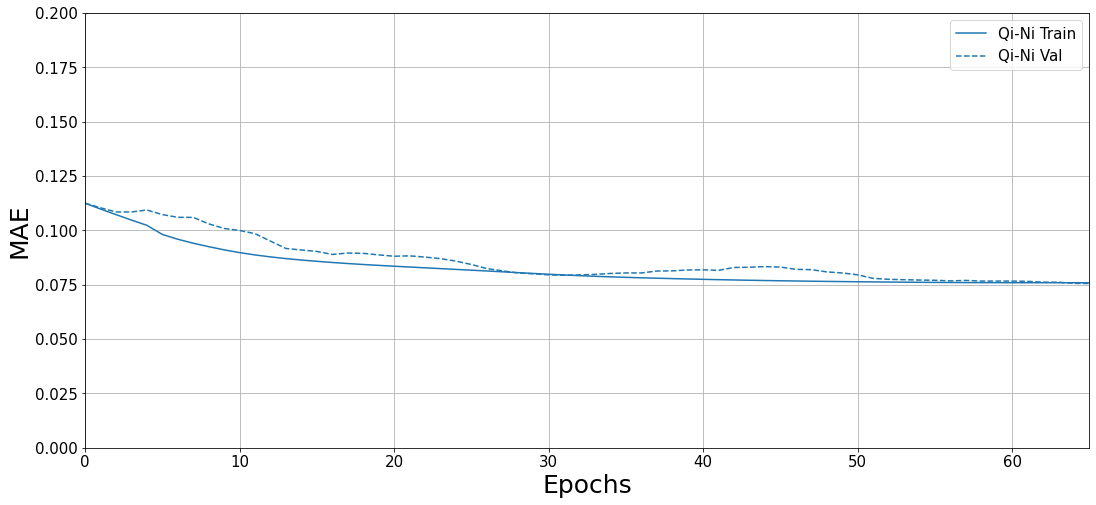

In [48]:
histories['qi-ni'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0,0.2])
plt.ylabel('MAE')

In [49]:
activ = "ReLU"
model4 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history4 = model4.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0217,  mae:0.0933,  mse:0.0217,  val_loss:0.0187,  val_mae:0.0966,  val_mse:0.0187,  
................................................

Text(0, 0.5, 'MAE')

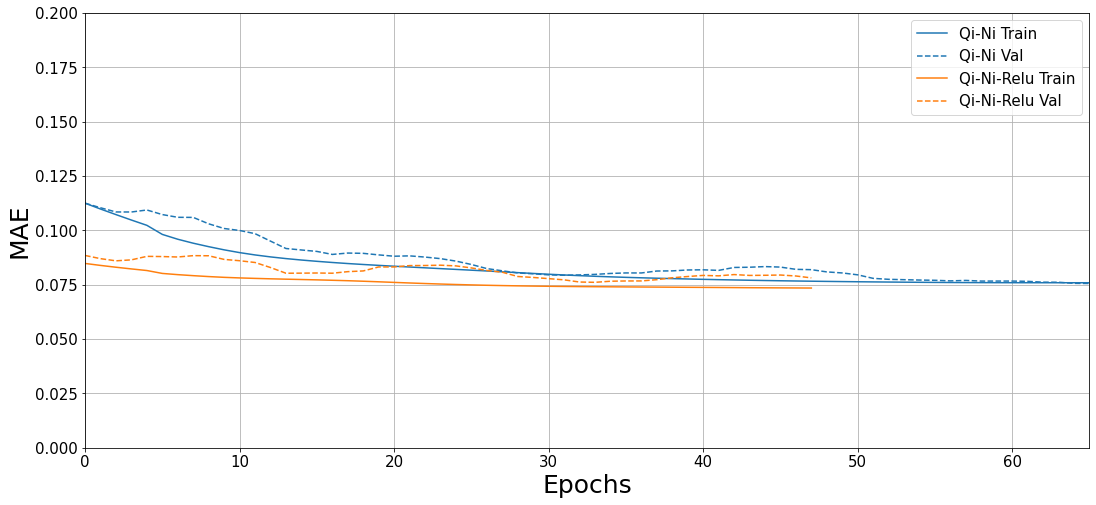

In [50]:
histories['qi-ni-ReLU'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.2])
plt.ylabel('MAE')

In [51]:
activ = "ReLU_Adam"
model6 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history6 = model6.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0200,  mae:0.0915,  mse:0.0200,  val_loss:0.0159,  val_mae:0.0854,  val_mse:0.0159,  
...............................

Text(0, 0.5, 'MAE')

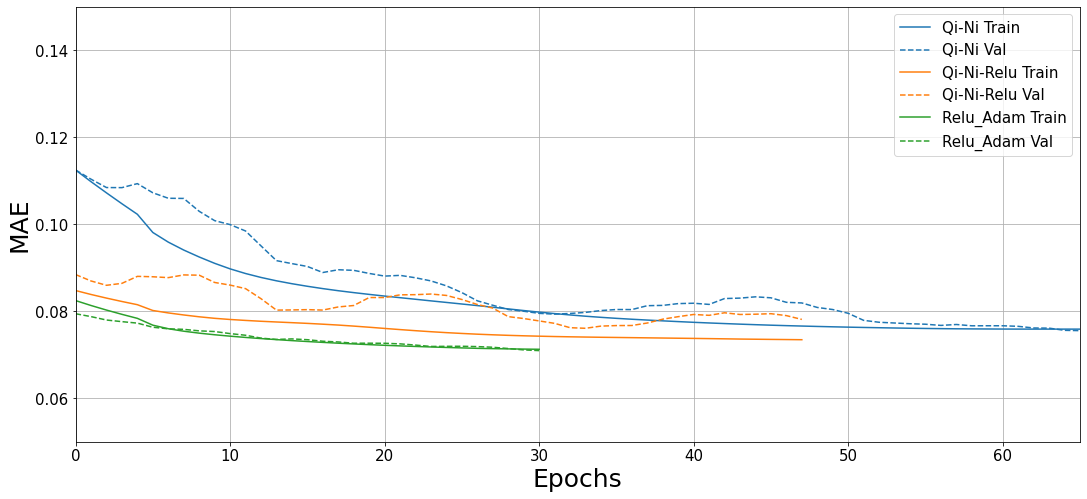

In [52]:
histories['ReLU_Adam'] = early_history6

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.05, 0.15])
plt.ylabel('MAE')

In [53]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

89544/89544 - 2s - loss: 0.0135 - mae: 0.0750 - mse: 0.0135
Testing set for model 1, Mean Abs Error:    0.07496


In [54]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

89544/89544 - 2s - loss: 0.0123 - mae: 0.0726 - mse: 0.0123
Testing set for model 4, Mean Abs Error:              0.07259


In [55]:
loss6, mae6, mse6 = model6.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 6, Mean Abs Error: {:20.5f}".format(mae6))

89544/89544 - 2s - loss: 0.0118 - mae: 0.0713 - mse: 0.0118
Testing set for model 6, Mean Abs Error:              0.07126


In [56]:
mae = [ mae1, mae4, mae6 ]
mae

[0.07495781, 0.072586514, 0.07126278]

In [57]:
mse = [ mse1, mse4, mse6 ]
mse

[0.013534595, 0.0122831, 0.011825344]

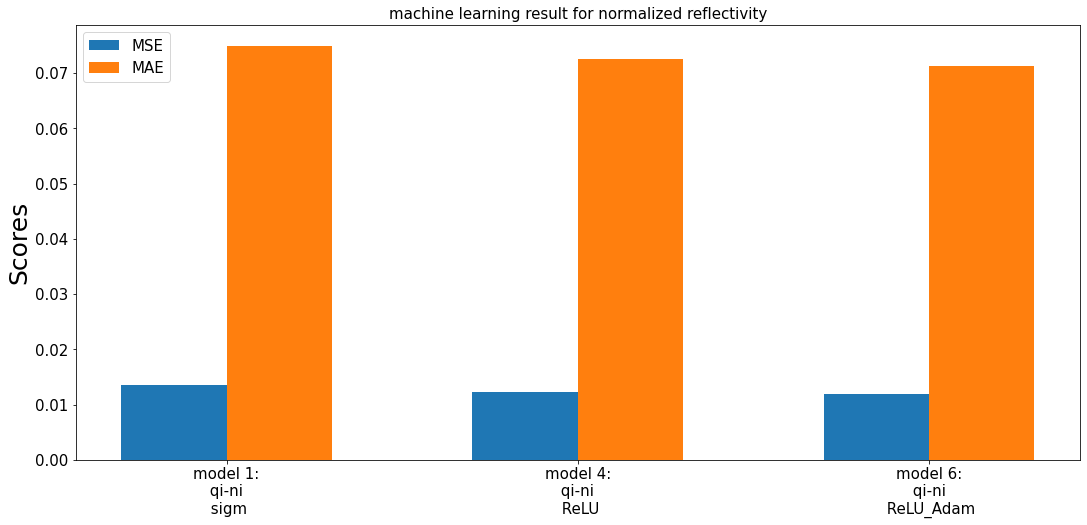

In [58]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1:\n qi-ni \n sigm',
 'model 4:\n qi-ni \n ReLU',
 'model 6:\n qi-ni \n ReLU_Adam' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized reflectivity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [59]:
test_true_z  = np.exp(test_labels.pop('z_s'))

In [60]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [61]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["z_s"])

In [62]:
p1.describe()

z_s
count  89544.000000
mean      -0.000117
std        0.991982
min       -3.396355
25%       -0.695029
50%       -0.156691
75%        0.801755
max        2.804686

In [63]:
train_labels_stats

count       mean       std        min       25%        50%       75%  \
z_s  416676.0 -11.291885  8.044381 -39.857662 -16.84658 -12.610948 -4.740618   

          max  
z_s  6.958543

In [64]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [65]:
test_predict1.describe()

z_s
count  8.954400e+04
mean   4.651619e+00
std    2.636007e+02
min    1.699755e-17
25%    4.653957e-08
50%    3.536534e-06
75%    7.889207e-03
max    7.843929e+04

In [66]:
test_predict1_z  = test_predict1['z_s']

In [67]:

p2 = pd.DataFrame(data=model4.predict(normed_test_data1), columns=["z_s"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_z = test_predict2['z_s']

In [68]:

p3 = pd.DataFrame(data=model6.predict(normed_test_data1), columns=["z_s"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_z = test_predict3['z_s']

### Maybe the ordering of the arrays is different? 

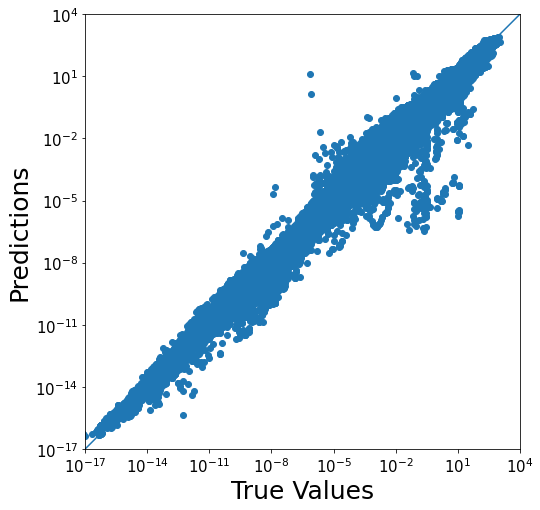

In [69]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-17, 1e4

a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict1_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

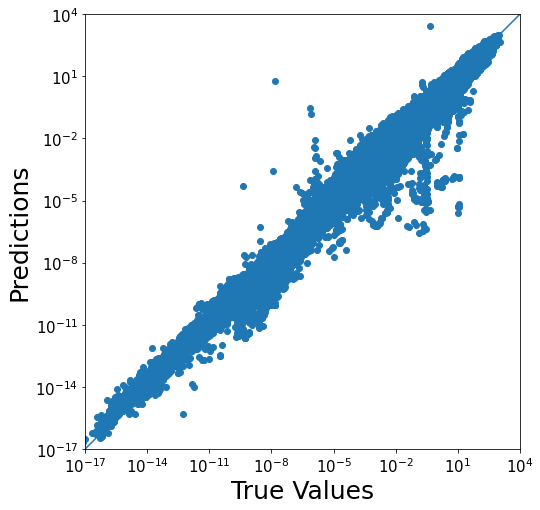

In [70]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict2_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

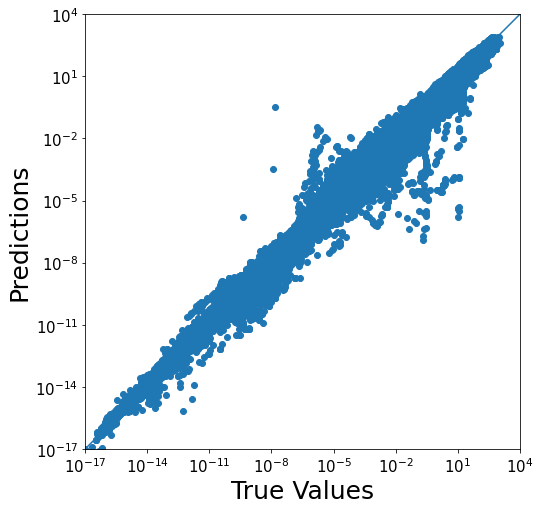

In [71]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict3_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [72]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [73]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [74]:
features = 'q_graupel, n_graupel, rmass_graupel, rvol_graupel'
labels   = 'z_graupel'
logtransform = np.array([True, True, True, True], dtype=bool)
save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/refl_graupel_model1_'+version+'.nc')
save2netcdf(model4,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/refl_graupel_model4_'+version+'.nc')
save2netcdf(model6,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/refl_graupel_model6_'+version+'.nc')

Saving model to saved_model_v2/refl_graupel_model1_08.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel
  Labels:     z_graupel
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/refl_graupel_model4_08.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel
  Labels:     z_graupel
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (